
#### Основы нейронных сетей


#### Многослойная сеть на PyTorch

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch

## Датасет
Мы будем работать с датасетом "Игрушка дьявола". Генерация и отрисовка датасета:

In [18]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D)) #N*K rows and D columns
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N) #Returns num evenly spaced samples, calculated over the interval [start, stop].
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

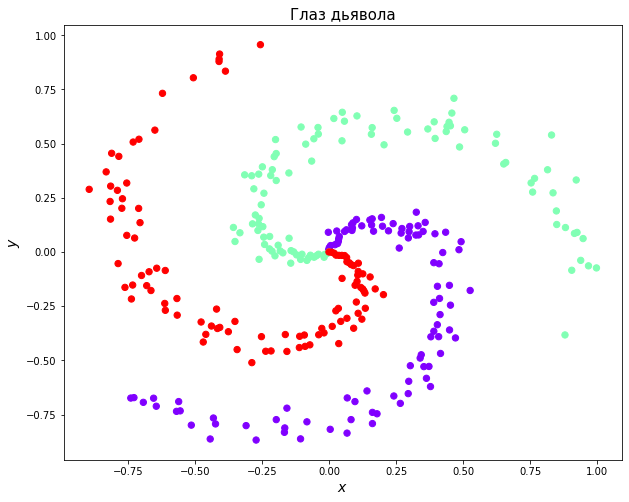

In [15]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Глаз дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

## PyTorch для нейронных сетей

Основная абстракция для построения нейронной сети --- это torch.nn.Module. Module --- это те кирпичики, из которых мы будем складывать любую нейронную сеть. Как мы узнали на лекции, для определения модуля достаточно задать методы Forward и Backward. Базовый класс для nn.Module в PyTorch:



In [2]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    :ivar training: Boolean represents whether this module is in training or
                    evaluation mode.
    :vartype training: bool
    


### Модуль Sequential

Основной класс в PyTorch для работы с нейронными сетями --- это  Sequential.  Sequential --- это шаблон для самой простой последовательной нейронной сети. Методы Forward и Backward заданы соответственно: мы пробрасываем выходы и градиенты через все слои, из которых состоит Module. Посмотрим, как это работает.

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть. 

In [20]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 32, 2, 2000, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Посмотрим, что у нас получилось. Пропустим мусорные данные через нашу модель методом forward.

In [21]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([2000, 2]), torch.Size([2000]), torch.Size([3, 2000]), torch.Size([3])]


In [22]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables 
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

c:\users\технодом\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.4033, 0.3120, 0.2848], grad_fn=<SelectBackward>)

## Код для генерации мини-батчей



In [3]:
from torch.autograd import Variable

In [24]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [25]:
batch_gen(X, y)[1].shape

torch.Size([128])

In [26]:
two_layer_net.forward(batch_gen(X,y)[0])

tensor([[0.4074, 0.3107, 0.2819],
        [0.4061, 0.3116, 0.2823],
        [0.3878, 0.3225, 0.2896],
        [0.4105, 0.3183, 0.2713],
        [0.4228, 0.3069, 0.2703],
        [0.4246, 0.2987, 0.2767],
        [0.3948, 0.3224, 0.2828],
        [0.3982, 0.3155, 0.2863],
        [0.4023, 0.3208, 0.2769],
        [0.4403, 0.3007, 0.2590],
        [0.4369, 0.3064, 0.2568],
        [0.3917, 0.3233, 0.2850],
        [0.4305, 0.3127, 0.2569],
        [0.4101, 0.3085, 0.2814],
        [0.4205, 0.3135, 0.2661],
        [0.3955, 0.3280, 0.2765],
        [0.3985, 0.3143, 0.2873],
        [0.4078, 0.3096, 0.2827],
        [0.3919, 0.3264, 0.2817],
        [0.3984, 0.3199, 0.2817],
        [0.4106, 0.3189, 0.2705],
        [0.4060, 0.3195, 0.2746],
        [0.3980, 0.3160, 0.2860],
        [0.3997, 0.3136, 0.2867],
        [0.4186, 0.3045, 0.2769],
        [0.4387, 0.3125, 0.2488],
        [0.3988, 0.3157, 0.2855],
        [0.3940, 0.3170, 0.2891],
        [0.4214, 0.3160, 0.2626],
        [0.430

Не забываем оборачивать данные (без этого градиенты не посчитать):

## Функция потерь и оптимизатор

In [27]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-1
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

## Обучение модели

In [28]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 140.04713439941406
1 135.35340881347656
2 129.01412963867188
3 131.4757843017578
4 121.04405975341797
5 126.72000885009766
6 123.70528411865234
7 119.3214111328125
8 116.12423706054688
9 130.6448974609375
10 126.40433502197266
11 123.00175476074219
12 132.74391174316406
13 127.42166900634766
14 122.76512908935547
15 129.92266845703125
16 132.4362335205078
17 125.63853454589844
18 130.404296875
19 131.80288696289062
20 123.45099639892578
21 127.33087158203125
22 118.24170684814453
23 127.26176452636719
24 112.53663635253906
25 121.34825134277344
26 123.5436019897461
27 111.15825653076172
28 121.286865234375
29 117.8465576171875
30 116.2778091430664
31 129.61643981933594
32 122.32210540771484
33 133.4359130859375
34 116.23157501220703
35 122.84071350097656
36 125.39987182617188
37 122.28441619873047
38 111.11512756347656
39 109.15097045898438
40 111.19818115234375
41 122.00514221191406
42 129.4909210205078
43 116.54730987548828
44 120.66661071777344
45 113.555908203125
46 118.956916809

374 91.76383972167969
375 94.1627426147461
376 91.82726287841797
377 89.39423370361328
378 89.14437866210938
379 94.32540130615234
380 81.24209594726562
381 85.61206817626953
382 91.45464324951172
383 90.7353286743164
384 82.78778076171875
385 90.68498229980469
386 103.67520141601562
387 104.05357360839844
388 105.2601089477539
389 94.85601043701172
390 90.60334014892578
391 81.13688659667969
392 85.66651916503906
393 90.1725845336914
394 82.8490982055664
395 86.91206359863281
396 81.7077407836914
397 88.80729675292969
398 91.18507385253906
399 107.6426010131836
400 92.70507049560547
401 80.36819458007812
402 93.04857635498047
403 95.68285369873047
404 114.29843139648438
405 94.9612808227539
406 88.37166595458984
407 91.25154876708984
408 87.67969512939453
409 99.40727996826172
410 95.0008544921875
411 98.50230407714844
412 90.03370666503906
413 87.54462432861328
414 78.1044692993164
415 82.2829360961914
416 86.5433120727539
417 99.26591491699219
418 77.99590301513672
419 83.3489227294

757 71.78883361816406
758 73.42498016357422
759 72.62559509277344
760 72.56382751464844
761 74.03961181640625
762 74.56018829345703
763 77.65145874023438
764 72.09814453125
765 70.67237091064453
766 72.67028045654297
767 72.85184478759766
768 72.30973815917969
769 72.98436737060547
770 73.25958251953125
771 72.77339935302734
772 74.052978515625
773 73.2506332397461
774 74.41610717773438
775 73.37748718261719
776 74.58108520507812
777 72.02018737792969
778 71.79681396484375
779 71.385009765625
780 72.74127197265625
781 74.63756561279297
782 73.8803939819336
783 73.64683532714844
784 71.6651840209961
785 73.12801361083984
786 72.1163330078125
787 72.85829162597656
788 78.23773956298828
789 72.85138702392578
790 72.34622955322266
791 72.87590789794922
792 73.17573547363281
793 72.2486343383789
794 72.70207214355469
795 72.18635559082031
796 72.1056900024414
797 75.4190673828125
798 71.47598266601562
799 72.9513931274414
800 71.96539306640625
801 71.8409423828125
802 72.48272705078125
803 

1141 71.8367691040039
1142 72.44239807128906
1143 70.68113708496094
1144 71.52682495117188
1145 72.5628890991211
1146 71.93876647949219
1147 72.24085235595703
1148 72.3531494140625
1149 71.05339813232422
1150 72.864013671875
1151 71.1095199584961
1152 73.21809387207031
1153 71.11680603027344
1154 71.53005981445312
1155 72.73219299316406
1156 76.58696746826172
1157 74.4745101928711
1158 73.21742248535156
1159 74.06790924072266
1160 75.66752624511719
1161 72.07792663574219
1162 71.2082748413086
1163 70.62296295166016
1164 71.97406005859375
1165 72.20388793945312
1166 71.98710632324219
1167 72.99369812011719
1168 73.85382843017578
1169 74.10186004638672
1170 75.65126037597656
1171 72.24382781982422
1172 72.18556213378906
1173 71.69242858886719
1174 72.6118392944336
1175 74.53305053710938
1176 71.73243713378906
1177 72.9491958618164
1178 71.65420532226562
1179 72.51239013671875
1180 72.91741943359375
1181 73.42180633544922
1182 74.64460754394531
1183 72.55133056640625
1184 74.0105667114257

1512 72.69893646240234
1513 70.61183166503906
1514 74.85162353515625
1515 71.6504898071289
1516 71.28533935546875
1517 73.47583770751953
1518 74.7769775390625
1519 72.78553771972656
1520 71.39298248291016
1521 73.08787536621094
1522 71.52880859375
1523 71.12139892578125
1524 71.34927368164062
1525 71.41400146484375
1526 72.39109802246094
1527 71.8602523803711
1528 71.40359497070312
1529 73.20213317871094
1530 78.5155029296875
1531 73.94153594970703
1532 75.31256866455078
1533 87.34827423095703
1534 106.78079986572266
1535 116.65178680419922
1536 95.90380096435547
1537 83.2166748046875
1538 83.34452819824219
1539 86.47237396240234
1540 83.27207946777344
1541 90.23817443847656
1542 119.34418487548828
1543 99.00956726074219
1544 91.06291198730469
1545 86.99555969238281
1546 76.22400665283203
1547 73.24502563476562
1548 75.54402923583984
1549 75.92835235595703
1550 71.5517578125
1551 73.65023803710938
1552 74.66478729248047
1553 71.41431427001953
1554 73.1199722290039
1555 73.3924026489257

1879 72.21611785888672
1880 71.90377044677734
1881 74.7475814819336
1882 72.58194732666016
1883 72.3043212890625
1884 72.5007095336914
1885 71.50676727294922
1886 70.73345947265625
1887 71.272216796875
1888 70.8493423461914
1889 71.98506927490234
1890 70.96265411376953
1891 71.60438537597656
1892 71.04169464111328
1893 73.63907623291016
1894 75.20796203613281
1895 72.04740905761719
1896 72.26786041259766
1897 72.93934631347656
1898 72.25703430175781
1899 71.94776916503906
1900 72.03961181640625
1901 72.7438735961914
1902 71.11231231689453
1903 71.71192169189453
1904 71.16006469726562
1905 72.3536605834961
1906 72.65187072753906
1907 72.40437316894531
1908 71.30602264404297
1909 71.00345611572266
1910 72.55501556396484
1911 71.16647338867188
1912 72.57402801513672
1913 72.91226196289062
1914 71.30561065673828
1915 72.47919464111328
1916 71.77029418945312
1917 73.66529846191406
1918 73.18494415283203
1919 71.95263671875
1920 70.91358184814453
1921 70.74263000488281
1922 71.37052917480469

2253 73.36902618408203
2254 72.35743713378906
2255 71.66793060302734
2256 71.1264877319336
2257 73.1783218383789
2258 73.26795959472656
2259 73.33256530761719
2260 71.05525970458984
2261 74.03050994873047
2262 73.91902923583984
2263 72.11231231689453
2264 70.67462158203125
2265 73.03448486328125
2266 73.37220001220703
2267 72.51447296142578
2268 70.9157485961914
2269 72.21632385253906
2270 71.07054901123047
2271 72.1241455078125
2272 71.12747955322266
2273 72.35516357421875
2274 70.78364562988281
2275 71.61920166015625
2276 72.84468841552734
2277 70.65709686279297
2278 71.20938873291016
2279 72.48932647705078
2280 73.15449523925781
2281 70.80780029296875
2282 72.80152130126953
2283 72.36283874511719
2284 72.39494323730469
2285 71.76826477050781
2286 72.00749969482422
2287 71.22089385986328
2288 71.90415954589844
2289 74.30834197998047
2290 74.2204360961914
2291 71.09064483642578
2292 71.6849594116211
2293 74.11737823486328
2294 73.49785614013672
2295 72.68035888671875
2296 74.046997070

2623 72.63350677490234
2624 72.0197525024414
2625 70.88929748535156
2626 71.26580047607422
2627 72.21599578857422
2628 71.9885482788086
2629 71.7616195678711
2630 73.2834701538086
2631 70.95571899414062
2632 71.53477478027344
2633 72.88951110839844
2634 72.45873260498047
2635 71.82917785644531
2636 72.89352416992188
2637 71.56442260742188
2638 72.2153549194336
2639 74.07592010498047
2640 70.73179626464844
2641 70.6828842163086
2642 71.63838958740234
2643 71.52924346923828
2644 74.8907470703125
2645 72.4733657836914
2646 71.67005920410156
2647 70.92579650878906
2648 72.24895477294922
2649 70.75194549560547
2650 71.89738464355469
2651 72.15242767333984
2652 71.85992431640625
2653 71.65286254882812
2654 71.20431518554688
2655 70.91679382324219
2656 74.21373748779297
2657 71.19843292236328
2658 72.06946563720703
2659 74.01542663574219
2660 72.62408447265625
2661 72.256591796875
2662 74.0322036743164
2663 72.41766357421875
2664 72.06330108642578
2665 72.30804443359375
2666 73.18540954589844

3003 71.71288299560547
3004 71.46218872070312
3005 72.96381378173828
3006 72.7288818359375
3007 72.35720825195312
3008 73.3278579711914
3009 71.93431854248047
3010 74.69367218017578
3011 71.99055480957031
3012 73.07379150390625
3013 72.01614379882812
3014 72.63583374023438
3015 71.39734649658203
3016 73.22400665283203
3017 73.2362060546875
3018 72.88513946533203
3019 71.79267120361328
3020 72.44522094726562
3021 72.34852600097656
3022 71.73771667480469
3023 73.69355010986328
3024 70.8104248046875
3025 71.48274230957031
3026 72.31954193115234
3027 75.94502258300781
3028 72.05316162109375
3029 72.17880249023438
3030 71.39384460449219
3031 71.292236328125
3032 73.09577178955078
3033 72.8752212524414
3034 70.7426528930664
3035 72.27330780029297
3036 71.35205078125
3037 70.82585144042969
3038 70.69994354248047
3039 73.34638214111328
3040 70.58816528320312
3041 72.22846984863281
3042 71.60919952392578
3043 71.47161102294922
3044 71.6532211303711
3045 72.87161254882812
3046 72.7931900024414
3

3372 71.6058349609375
3373 73.51797485351562
3374 71.9162368774414
3375 71.67784881591797
3376 72.8214340209961
3377 71.07303619384766
3378 70.62519836425781
3379 72.26384735107422
3380 72.28364562988281
3381 72.3037109375
3382 72.04170227050781
3383 71.36698150634766
3384 73.13410186767578
3385 71.14845275878906
3386 71.63249206542969
3387 72.4500961303711
3388 70.70179748535156
3389 71.32845306396484
3390 71.5061264038086
3391 70.7736587524414
3392 71.95446014404297
3393 71.86215209960938
3394 71.96499633789062
3395 71.08599853515625
3396 74.19584655761719
3397 73.57444763183594
3398 73.50566101074219
3399 71.74620056152344
3400 73.48494720458984
3401 71.13626861572266
3402 70.87973022460938
3403 72.03392791748047
3404 73.05621337890625
3405 71.44493865966797
3406 72.30591583251953
3407 71.32894897460938
3408 71.78715515136719
3409 72.0074234008789
3410 70.77751159667969
3411 72.38045501708984
3412 70.84683990478516
3413 70.59058380126953
3414 71.78410339355469
3415 70.93360137939453

3742 70.94058990478516
3743 73.70964813232422
3744 71.70404815673828
3745 73.20984649658203
3746 76.54521942138672
3747 74.63885498046875
3748 72.1045150756836
3749 71.45988464355469
3750 71.30964660644531
3751 71.98145294189453
3752 72.22753143310547
3753 71.23811340332031
3754 70.90705871582031
3755 71.45231628417969
3756 72.64677429199219
3757 71.01507568359375
3758 71.0507583618164
3759 70.9050521850586
3760 72.05339050292969
3761 71.84083557128906
3762 70.94185638427734
3763 70.66134643554688
3764 71.36641693115234
3765 71.56455993652344
3766 70.79085540771484
3767 74.31614685058594
3768 71.49102020263672
3769 75.18783569335938
3770 71.54193115234375
3771 70.6341552734375
3772 71.42903137207031
3773 70.87532043457031
3774 71.50773620605469
3775 70.90673065185547
3776 71.0702896118164
3777 71.48540496826172
3778 72.10560607910156
3779 72.44886779785156
3780 70.8589859008789
3781 70.59811401367188
3782 73.40738677978516
3783 72.44840240478516
3784 71.26011657714844
3785 71.561439514

4130 72.63097381591797
4131 71.65280151367188
4132 73.62134552001953
4133 72.7400131225586
4134 70.95052337646484
4135 73.38965606689453
4136 71.60315704345703
4137 72.05868530273438
4138 70.62041473388672
4139 71.5973129272461
4140 73.60256958007812
4141 72.63006591796875
4142 72.07987976074219
4143 72.27964782714844
4144 72.27349090576172
4145 73.80406951904297
4146 73.30182647705078
4147 71.57953643798828
4148 71.81078338623047
4149 73.64332580566406
4150 74.69050598144531
4151 71.26364135742188
4152 72.15323638916016
4153 73.03414154052734
4154 73.19708251953125
4155 72.19945526123047
4156 70.72522735595703
4157 71.30207824707031
4158 71.82342529296875
4159 71.30167388916016
4160 71.70930480957031
4161 71.96617126464844
4162 70.64942932128906
4163 71.71310424804688
4164 72.43966674804688
4165 72.2440414428711
4166 71.78909301757812
4167 70.85324096679688
4168 70.61793518066406
4169 70.97132873535156
4170 70.59619140625
4171 71.01036071777344
4172 71.67408752441406
4173 72.063995361

4503 72.4828109741211
4504 71.55220794677734
4505 72.00714111328125
4506 71.39642333984375
4507 72.06615447998047
4508 71.63973999023438
4509 74.68000030517578
4510 72.88394165039062
4511 72.16465759277344
4512 72.53343200683594
4513 71.93666076660156
4514 71.691162109375
4515 71.4590835571289
4516 71.24303436279297
4517 72.61763763427734
4518 72.29013061523438
4519 73.57477569580078
4520 71.30496215820312
4521 70.83894348144531
4522 73.60436248779297
4523 70.75296783447266
4524 71.81019592285156
4525 71.3702392578125
4526 72.04750061035156
4527 72.69847106933594
4528 71.82250213623047
4529 73.05725860595703
4530 71.43460083007812
4531 71.98905944824219
4532 71.48643493652344
4533 70.59159088134766
4534 71.51249694824219
4535 70.80973052978516
4536 71.62168884277344
4537 70.5915298461914
4538 70.64994812011719
4539 71.06874084472656
4540 71.53358459472656
4541 71.49980163574219
4542 70.80467224121094
4543 71.93562316894531
4544 73.37667846679688
4545 73.32726287841797
4546 71.566314697

4891 71.36579132080078
4892 73.39906311035156
4893 72.56057739257812
4894 73.59819793701172
4895 71.00384521484375
4896 70.89942169189453
4897 70.96390533447266
4898 71.08187866210938
4899 71.07420349121094
4900 70.88062286376953
4901 73.8533935546875
4902 72.069580078125
4903 70.68191528320312
4904 71.49960327148438
4905 70.60635375976562
4906 72.55862426757812
4907 72.81682586669922
4908 73.45284271240234
4909 71.28311157226562
4910 70.61100006103516
4911 71.1346206665039
4912 70.68888092041016
4913 71.0943374633789
4914 72.44093322753906
4915 71.16512298583984
4916 70.63287353515625
4917 71.49639892578125
4918 71.52643585205078
4919 70.7999267578125
4920 72.36520385742188
4921 74.25898742675781
4922 73.87659454345703
4923 71.77738952636719
4924 71.03782653808594
4925 74.07006072998047
4926 73.1316909790039
4927 73.42337799072266
4928 71.31095886230469
4929 71.9703369140625
4930 71.89091491699219
4931 70.8630599975586
4932 71.7962875366211
4933 71.98503875732422
4934 71.4419479370117

5268 71.42545318603516
5269 72.36450958251953
5270 70.70968627929688
5271 71.54074096679688
5272 71.1842041015625
5273 71.65494537353516
5274 71.71987915039062
5275 71.34418487548828
5276 71.89339447021484
5277 70.86753845214844
5278 70.58765411376953
5279 70.960693359375
5280 74.01568603515625
5281 70.98562622070312
5282 72.81454467773438
5283 72.07337188720703
5284 72.60746765136719
5285 72.07463836669922
5286 71.95021057128906
5287 78.28715515136719
5288 77.02986145019531
5289 72.2086410522461
5290 70.6263427734375
5291 71.28655242919922
5292 70.67015838623047
5293 72.48845672607422
5294 71.10881042480469
5295 71.45987701416016
5296 71.11534118652344
5297 72.35437774658203
5298 70.65813446044922
5299 70.8797836303711
5300 71.41240692138672
5301 71.90164184570312
5302 71.57390594482422
5303 71.76343536376953
5304 70.61823272705078
5305 72.93257904052734
5306 73.5702896118164
5307 70.69720458984375
5308 70.62086486816406
5309 72.55223083496094
5310 73.03861236572266
5311 71.5622711181

5630 71.34469604492188
5631 72.6480712890625
5632 71.19304656982422
5633 71.62313079833984
5634 71.2784423828125
5635 71.08867645263672
5636 70.98202514648438
5637 70.81500244140625
5638 71.35128021240234
5639 71.5413589477539
5640 71.53327178955078
5641 72.45207214355469
5642 70.71268463134766
5643 71.30967712402344
5644 72.36504364013672
5645 71.71012878417969
5646 70.73385620117188
5647 71.61457824707031
5648 72.45425415039062
5649 71.81554412841797
5650 72.55667877197266
5651 71.47248077392578
5652 70.75186157226562
5653 71.63117980957031
5654 72.86422729492188
5655 75.1486587524414
5656 70.99000549316406
5657 75.27288818359375
5658 71.103271484375
5659 73.84229278564453
5660 71.47937774658203
5661 71.43907165527344
5662 72.56761932373047
5663 72.15834045410156
5664 72.96786499023438
5665 72.34498596191406
5666 72.30072021484375
5667 73.66919708251953
5668 71.9236068725586
5669 71.0163803100586
5670 71.07202911376953
5671 70.99840545654297
5672 72.23635864257812
5673 71.26696014404

5994 71.09986877441406
5995 70.97405242919922
5996 72.36219024658203
5997 71.81720733642578
5998 71.5091781616211
5999 73.63187408447266
6000 72.17945098876953
6001 73.0062026977539
6002 71.63504791259766
6003 73.56139373779297
6004 73.26548767089844
6005 71.16168212890625
6006 72.27407836914062
6007 71.00479125976562
6008 74.19573211669922
6009 71.37882995605469
6010 72.0057601928711
6011 72.36241912841797
6012 72.43212890625
6013 71.58563232421875
6014 71.88423919677734
6015 71.30911254882812
6016 71.66993713378906
6017 71.35107421875
6018 73.6198501586914
6019 71.72091674804688
6020 71.45918273925781
6021 72.9527816772461
6022 71.154296875
6023 71.66504669189453
6024 71.50482940673828
6025 71.38224029541016
6026 70.59303283691406
6027 72.48094940185547
6028 70.61966705322266
6029 70.59386444091797
6030 71.13172149658203
6031 72.70160675048828
6032 70.91207122802734
6033 71.53475952148438
6034 71.8990249633789
6035 72.64875793457031
6036 70.82684326171875
6037 71.2625732421875
6038 7

6371 71.82569885253906
6372 72.25289154052734
6373 72.52571868896484
6374 73.22544860839844
6375 71.59786224365234
6376 72.5992202758789
6377 71.59532928466797
6378 71.45529174804688
6379 73.05258178710938
6380 71.53614044189453
6381 71.58451843261719
6382 70.59271240234375
6383 71.91492462158203
6384 72.42141723632812
6385 71.25789642333984
6386 71.86151885986328
6387 71.83872985839844
6388 71.45392608642578
6389 71.65238189697266
6390 71.91629791259766
6391 71.79619598388672
6392 73.02962493896484
6393 71.58428192138672
6394 71.72162628173828
6395 70.79232788085938
6396 72.4975814819336
6397 72.00144958496094
6398 70.59086608886719
6399 72.94036102294922
6400 70.69193267822266
6401 71.41178131103516
6402 71.02561950683594
6403 73.42289733886719
6404 71.84293365478516
6405 72.11869049072266
6406 73.44325256347656
6407 72.13770294189453
6408 71.91094207763672
6409 71.97570037841797
6410 72.2798080444336
6411 71.66659545898438
6412 71.04315185546875
6413 70.68498992919922
6414 72.516990

6746 71.3021240234375
6747 71.99836730957031
6748 72.62090301513672
6749 71.42107391357422
6750 71.65846252441406
6751 71.58490753173828
6752 71.55345153808594
6753 72.87239074707031
6754 71.8243637084961
6755 71.06402587890625
6756 70.95771026611328
6757 72.43846893310547
6758 72.12723541259766
6759 71.40663146972656
6760 74.3857192993164
6761 71.95367431640625
6762 72.36238861083984
6763 71.36824798583984
6764 72.52812194824219
6765 71.65536499023438
6766 71.53118133544922
6767 73.02191925048828
6768 73.46007537841797
6769 73.23133850097656
6770 71.61528015136719
6771 71.53892517089844
6772 71.7457504272461
6773 71.60774230957031
6774 73.03361511230469
6775 72.01081085205078
6776 72.39665222167969
6777 71.50912475585938
6778 71.42957305908203
6779 72.98181915283203
6780 71.44402313232422
6781 70.64325714111328
6782 72.31952667236328
6783 71.76107025146484
6784 71.36589813232422
6785 72.28292846679688
6786 71.4058837890625
6787 71.75115203857422
6788 70.58595275878906
6789 73.05651855

7118 71.49962615966797
7119 70.82152557373047
7120 72.33885955810547
7121 71.87506103515625
7122 70.79546356201172
7123 70.59090423583984
7124 71.93624114990234
7125 70.66313171386719
7126 71.13777160644531
7127 73.4249267578125
7128 71.80116271972656
7129 72.90424346923828
7130 72.12388610839844
7131 71.79586029052734
7132 74.25141906738281
7133 72.19481658935547
7134 71.58570861816406
7135 71.8990707397461
7136 72.96170043945312
7137 73.75247955322266
7138 72.79692840576172
7139 70.69261169433594
7140 71.7897720336914
7141 73.88892364501953
7142 73.35530853271484
7143 71.02539825439453
7144 71.08773803710938
7145 72.29620361328125
7146 72.13573455810547
7147 73.56018829345703
7148 70.62493896484375
7149 70.67669677734375
7150 71.6396484375
7151 72.96797943115234
7152 71.94052124023438
7153 71.5313720703125
7154 71.73391723632812
7155 71.7559814453125
7156 73.56097412109375
7157 72.37103271484375
7158 74.07169342041016
7159 70.8281021118164
7160 70.70365142822266
7161 72.5206298828125

7503 71.25801849365234
7504 72.62242889404297
7505 72.52642822265625
7506 71.26319885253906
7507 71.5858154296875
7508 71.79668426513672
7509 71.12113189697266
7510 71.24857330322266
7511 71.35974884033203
7512 71.57324981689453
7513 73.43352508544922
7514 72.12158966064453
7515 71.72821044921875
7516 71.60626220703125
7517 70.72303009033203
7518 71.62416076660156
7519 71.82025909423828
7520 70.63713073730469
7521 73.86038208007812
7522 71.09457397460938
7523 71.57328033447266
7524 71.42041015625
7525 71.63491821289062
7526 70.62785339355469
7527 71.85273742675781
7528 71.56444549560547
7529 72.4473648071289
7530 71.6574478149414
7531 74.56980895996094
7532 71.49616241455078
7533 71.42374420166016
7534 71.91438293457031
7535 71.44117736816406
7536 71.1387939453125
7537 73.88472747802734
7538 70.82797241210938
7539 73.27139282226562
7540 71.172607421875
7541 71.79344940185547
7542 72.84722137451172
7543 70.64765930175781
7544 70.95721435546875
7545 71.2887191772461
7546 71.707275390625


7870 73.48057556152344
7871 72.13732147216797
7872 71.1541976928711
7873 71.46244812011719
7874 70.92736053466797
7875 71.53689575195312
7876 71.08657836914062
7877 71.49349212646484
7878 71.8701171875
7879 72.06439971923828
7880 70.8125991821289
7881 71.52960205078125
7882 72.2567138671875
7883 71.56671905517578
7884 72.52168273925781
7885 71.60269927978516
7886 74.07255554199219
7887 71.79290008544922
7888 71.59632873535156
7889 71.61088562011719
7890 70.90814208984375
7891 72.44684600830078
7892 70.65067291259766
7893 71.57318878173828
7894 71.48966979980469
7895 72.23127746582031
7896 73.04345703125
7897 70.61408233642578
7898 71.61084747314453
7899 71.11817932128906
7900 72.31729888916016
7901 72.20414733886719
7902 70.73770904541016
7903 73.64402770996094
7904 76.0392837524414
7905 71.21231842041016
7906 71.84027862548828
7907 71.75411224365234
7908 71.40996551513672
7909 71.72063446044922
7910 72.1175765991211
7911 71.52735900878906
7912 71.47209930419922
7913 71.73532104492188


8237 70.64289093017578
8238 72.5208969116211
8239 71.01768493652344
8240 70.6917953491211
8241 70.59127807617188
8242 71.38936614990234
8243 73.46279907226562
8244 70.66178894042969
8245 72.40360260009766
8246 72.42049407958984
8247 71.8132095336914
8248 71.4057388305664
8249 71.6994857788086
8250 71.05744171142578
8251 70.655029296875
8252 70.73607635498047
8253 70.587646484375
8254 71.6380615234375
8255 75.846923828125
8256 70.86354064941406
8257 72.6535415649414
8258 70.58977508544922
8259 71.97196960449219
8260 72.01520538330078
8261 73.0376968383789
8262 71.11668395996094
8263 71.30136108398438
8264 72.82460021972656
8265 74.08162689208984
8266 73.64744567871094
8267 74.48211669921875
8268 71.59075927734375
8269 72.10064697265625
8270 71.27495574951172
8271 71.06168365478516
8272 72.70381164550781
8273 71.20991516113281
8274 70.59077453613281
8275 72.7358169555664
8276 70.62161254882812
8277 72.16337585449219
8278 71.25199127197266
8279 71.03092956542969
8280 71.16150665283203
828

8614 73.69723510742188
8615 73.09886169433594
8616 70.97949981689453
8617 75.00399017333984
8618 73.33758544921875
8619 73.4814224243164
8620 71.7542495727539
8621 70.59822845458984
8622 70.72109985351562
8623 72.5500259399414
8624 72.28640747070312
8625 71.79994201660156
8626 71.78340911865234
8627 70.81024932861328
8628 72.98762512207031
8629 72.32598876953125
8630 71.0369644165039
8631 70.96826171875
8632 70.82750701904297
8633 70.69401550292969
8634 71.31270599365234
8635 70.62564849853516
8636 71.41989135742188
8637 72.13526916503906
8638 70.77800750732422
8639 70.94775390625
8640 71.00048065185547
8641 71.56318664550781
8642 70.63863372802734
8643 72.35692596435547
8644 71.51934814453125
8645 71.61526489257812
8646 74.0218505859375
8647 73.07899475097656
8648 70.62179565429688
8649 71.39964294433594
8650 71.4852294921875
8651 72.51054382324219
8652 70.69137573242188
8653 73.41932678222656
8654 70.64623260498047
8655 72.03693389892578
8656 71.51483154296875
8657 72.40973663330078


9000 73.16768646240234
9001 72.60067749023438
9002 72.35401153564453
9003 70.63799285888672
9004 71.44195556640625
9005 71.33109283447266
9006 71.3240737915039
9007 70.59939575195312
9008 72.10464477539062
9009 71.74713897705078
9010 70.59405517578125
9011 71.60787963867188
9012 72.4669189453125
9013 70.90264129638672
9014 70.81509399414062
9015 73.53324890136719
9016 77.57288360595703
9017 72.74964904785156
9018 71.0462875366211
9019 71.72830200195312
9020 71.51053619384766
9021 70.87772369384766
9022 71.98902130126953
9023 71.04515075683594
9024 71.01966094970703
9025 71.03448486328125
9026 74.74178314208984
9027 72.86251831054688
9028 70.73051452636719
9029 72.63597106933594
9030 71.48896789550781
9031 71.65370178222656
9032 70.68106079101562
9033 72.58080291748047
9034 71.74007415771484
9035 71.81910705566406
9036 71.3541030883789
9037 70.63501739501953
9038 71.2588119506836
9039 70.62506103515625
9040 70.92266845703125
9041 72.75605773925781
9042 71.41934967041016
9043 70.58744049

9374 71.31735229492188
9375 71.41422271728516
9376 72.31027221679688
9377 71.9240951538086
9378 70.65045166015625
9379 71.6611557006836
9380 71.06365203857422
9381 71.43438720703125
9382 70.97161865234375
9383 71.12616729736328
9384 71.67766571044922
9385 72.16290283203125
9386 72.54472351074219
9387 70.93054962158203
9388 71.5011215209961
9389 70.72318267822266
9390 71.62433624267578
9391 70.95828247070312
9392 73.31072235107422
9393 70.76922607421875
9394 71.89028930664062
9395 73.37197875976562
9396 70.61053466796875
9397 70.81537628173828
9398 71.7455062866211
9399 71.2774429321289
9400 70.62873077392578
9401 73.08365631103516
9402 71.06128692626953
9403 72.32843017578125
9404 72.25457000732422
9405 74.04318237304688
9406 71.65707397460938
9407 70.75965118408203
9408 72.0760498046875
9409 70.84608459472656
9410 71.00273132324219
9411 71.53643798828125
9412 73.18623352050781
9413 75.07157135009766
9414 72.4791030883789
9415 71.73967742919922
9416 71.21484375
9417 72.55367279052734
9

9741 76.06412506103516
9742 70.8989028930664
9743 72.24068450927734
9744 72.42789459228516
9745 72.39563751220703
9746 71.74207305908203
9747 71.72384643554688
9748 70.96867370605469
9749 73.38172912597656
9750 70.67324829101562
9751 72.5205078125
9752 74.1104965209961
9753 72.15186309814453
9754 72.62287902832031
9755 71.02395629882812
9756 70.7503662109375
9757 71.4982681274414
9758 72.24336242675781
9759 73.03711700439453
9760 74.58881378173828
9761 71.12200927734375
9762 71.80620574951172
9763 71.9037857055664
9764 71.4341812133789
9765 72.62150573730469
9766 73.13961029052734
9767 72.28401184082031
9768 70.58808898925781
9769 75.96694946289062
9770 71.99464416503906
9771 70.59683227539062
9772 70.71903228759766
9773 71.02477264404297
9774 71.72547149658203
9775 70.62081146240234
9776 72.10772705078125
9777 72.84016418457031
9778 71.15997314453125
9779 72.34725952148438
9780 70.87176513671875
9781 71.2370834350586
9782 70.89021301269531
9783 71.0002212524414
9784 71.01573944091797


**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

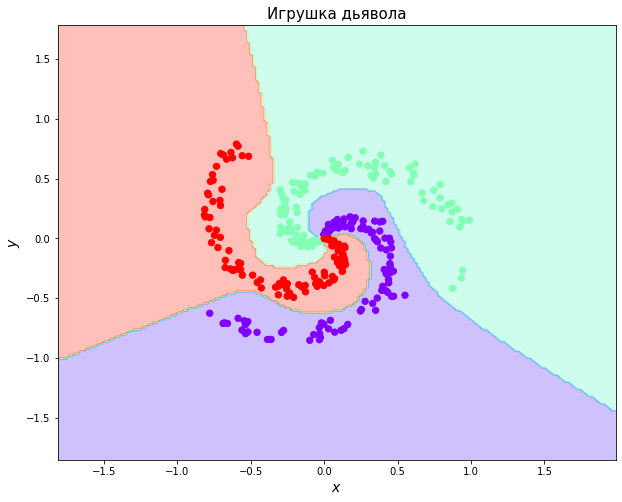

In [29]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

---

### Задача 1

Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

In [18]:
# Ваш код здесь (можно (и нужно) создавать больше ячеек)
from keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# np.set_printoptions(threshold=10000000000)
# # trainX[0]
# for i in range(3):
# 	# define subplot
# 	plt.subplot(330 + 1 + i)
# 	# plot raw pixel data
# 	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# # show the figure
# plt.show()
mnist.load_data()

AttributeError: 'tuple' object has no attribute 'shape'

In [5]:
# N, D_in, H, D_out = 64, 784, 700, 9
from torch import nn
import torch

# # Use the nn package to define our model and loss function.
# net = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Sigmoid(),
#     torch.nn.Linear(H, D_out),
#     torch.nn.Softmax()
# )
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [6]:
x_batch = torch.tensor(trainX[:3], dtype=torch.float32)
y_batch = torch.tensor(trainy[:3], dtype=torch.float32)

NN = NeuralNetwork()
# NN = net
# compute outputs given inputs, both are variables 
y_predicted = NN.linear_relu_stack(x_batch[0])

# y_predicted  # display what we've got
x_batch.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 784x512)

In [70]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X)), Variable(torch.LongTensor(y))

In [64]:
NN.forward(batch_gen(trainX, trainy)[0])

tensor([[-13.4030,   5.2809,  -3.5720,  ...,  -5.4370,  -7.2538,   0.3349],
        [-14.6938,   4.9847,  -6.4121,  ...,  -2.1336,  -6.3189,   2.5695],
        [-13.3449,  13.6489,   0.2607,  ...,  -0.4989, -14.0258,   0.7195],
        ...,
        [-16.1740,   3.8345,  -8.9994,  ...,   3.3855,  -4.0999,   2.3097],
        [-18.5349,   5.2778,  -4.8256,  ...,  -8.7104, -10.8818,  -1.3491],
        [ -2.2133,   8.4456,  -3.8044,  ...,   0.3850,  -2.6007,   8.5607]],
       grad_fn=<AddmmBackward>)

In [7]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-1
optimizer = torch.optim.SGD(NN.parameters(), lr=learning_rate)

c:\users\технодом\appdata\local\programs\python\python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [14]:
# for t in range(20):
# #     x_batch, y_batch = batch_gen(X, y)
#     x_batch, y_batch = batch_gen(trainX, trainy)
    
#     # forward
#     y_pred = NN.forward(x_batch)

#     # loss
#     loss = loss_fn(y_pred, y_batch)
#     print('{} {}'.format(t, loss.data))

#     # ЗАНУЛЯЕМ!
#     optimizer.zero_grad()

#     # backward
#     loss.backward()

#     # ОБНОВЛЯЕМ! 
#     optimizer.step()
for epoch in range(10):
    NN.train()

    for data in mnist.load_data():
        (x, y) = data
        optimizer.zero_grad()
        output = NN(x.view(-1, 28*28))
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

ValueError: Type must be a sub-type of ndarray type

In [ ]:
correct, total = 0, 0
with t.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

In [ ]:
plt.imshow(x[3].view(28, 28))
plt.show()
print(t.argmax(net(x[3].view(-1, 784))[0]))

In [13]:
import torch as t
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
net = Net()

In [4]:
cross_el = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters(), lr=0.001) #e-1
epoch = 10

for epoch in range(epoch):
    net.train()

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss.backward()
        optimizer.step()

In [6]:
correct, total = 0, 0
with t.no_grad():
    for data in test_loader:
        x, y = data
        output = net(x.view(-1, 784))
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct +=1
            total +=1
print(f'accuracy: {round(correct/total, 3)}')

accuracy: 0.967


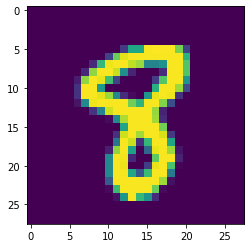

tensor(8)


In [7]:
plt.imshow(x[3].view(28, 28))
plt.show()
print(t.argmax(net(x[3].view(-1, 784))[0]))

Несколько советов о том, как строить нейросети. Код выполнен на фреймворке Keras, но, кажется, он довольно интуитивно понятен.

### Задача 2
https://pypi.org/project/python-mnist/

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*